# Exploratory Data Analysis of Pneumothorax dataset

## Preparations

### Imports

In [16]:
# Data handling imports
import pandas as pd
pd.reset_option('max_colwidth')
import numpy as np

# Read DICOM format
import pydicom

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# General purpose imports
import os
from glob import glob

# Benchmark \ Baseline U-net
# pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

### Set Paths

In [17]:
# general folder path
user = 'roy' # 'or' \ 'roy'
if user == 'roy':
    folder_path = '/Users/royrubin/Downloads/siim/' 
else:
    folder_path = '... OR - your path'
    
# paths for files
train_rle_encodings_file_path = os.path.join(folder_path, 'train-rle.csv')
train_files_path = os.path.join(folder_path, 'dicom-images-train/')
test_files_path = os.path.join(folder_path, 'dicom-images-test/')

print(f'train_rle_encodings_file_path: {train_rle_encodings_file_path}')
print(f'train_files_path: {train_files_path}')
print(f'test_files_path: {test_files_path}')

train_rle_encodings_file_path: /Users/royrubin/Downloads/siim/train-rle.csv
train_files_path: /Users/royrubin/Downloads/siim/dicom-images-train/
test_files_path: /Users/royrubin/Downloads/siim/dicom-images-test/


### Handle uncomfotable and uneeded subdirs

In [18]:
#reading all dcm files into train and text
if user == 'roy':
    # then i downloaded the data from: 'https://www.kaggle.com/datasets/seesee/siim-train-test'
    train_file_names = sorted(glob(train_files_path + "*/*/*.dcm"))
    test_file_names = sorted(glob(test_files_path + "*/*/*.dcm")) # sorted([f for f in listdir(test_files_path) if '.dcm' in f])
    
print(f"\ntrain files: amount {len(train_file_names)}, examples: \n{train_file_names[0]}\n{train_file_names[1]}")
print(f"\ntest files: amount {len(test_file_names)}, examples: \n{test_file_names[0]}\n{test_file_names[1]}")


train files: amount 12089, examples: 
/Users/royrubin/Downloads/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026/1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
/Users/royrubin/Downloads/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10000.1517875220.938529/1.2.276.0.7230010.3.1.3.8323329.10000.1517875220.938528/1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.dcm

test files: amount 3205, examples: 
/Users/royrubin/Downloads/siim/dicom-images-test/_/_/ID_0011fe81e.dcm
/Users/royrubin/Downloads/siim/dicom-images-test/_/_/ID_003206608.dcm


### Read the RLE encondings csv

In [19]:
%%time
# read train-rle.csv
train_rle_encodings_df = pd.read_csv(train_rle_encodings_file_path, delimiter=",")
train_rle_encodings_df.rename(columns={" EncodedPixels": "EncodedPixels"}, inplace=True)

CPU times: user 79.6 ms, sys: 23.3 ms, total: 103 ms
Wall time: 118 ms


In [20]:
print(f'size {train_rle_encodings_df.shape}')
train_rle_encodings_df.head(3)

size (12954, 2)


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1


### Read images train data from DICOM format

In [ ]:
%%time
# around 2 mins
temp = [{'UID': pydicom.read_file(file_name).SOPInstanceUID, 'Image': pydicom.read_file(file_name).pixel_array} 
                for file_name in train_file_names]
train_images_df = pd.DataFrame(temp)

In [ ]:
print(f'size {len(train_images_df)}')
print(f'shape of single image {train_images_df.iloc[0].Image.shape}')
train_images_df.head(3)

### Read metadata train data from DICOM format

In [ ]:
%%time
# around 30 secs
train_metadata = [pydicom.dcmread(file_name) for file_name in train_file_names]

In [ ]:
print(type(train_metadata[0]))

### Function for viewing single patient data extracted from pydicom format

In [ ]:
def show_patient_data(patient_file_name: str):
    #displaying metadata
    data = pydicom.dcmread(patient_file_name)
    print(data)
    
    #displaying the image
    img = pydicom.read_file(patient_file_name).pixel_array
    plt.figure(0)
    plt.grid(False)
    plt.imshow(img, cmap='bone')

### Function for generating metadata pandas dataframe

In [ ]:
def generate_metadata_dataframe(train_metadata: list, masks: pd.DataFrame):
    
    patients = pd.DataFrame()

    for data in train_metadata:
        patient = dict()
        
        # save the wanted features from the dicom foramt
        patient["UID"] = data.SOPInstanceUID
        patient["PatientID"] = data.PatientID        
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["Columns"] = data.Columns
        patient["Rows"] = data.Rows
        patient["PatientOrientation"] = data.PatientOrientation
        patient["PhotometricInterpretation"] = data.PhotometricInterpretation
        patient["PixelSpacing"] = data.PixelSpacing
        patient["SamplesPerPixel"] = data.SamplesPerPixel
        patient["PixelSpacing"] = data.PixelSpacing

        # add a label to the data - if the patient has the disease or not
        try:
            encoded_pixels = masks[masks["ImageId"] == patient["UID"]].values[0][1]
            # patient["EncodedPixels"] = encoded_pixels
            patient["Label"] = 'Healthy' if encoded_pixels == '-1' else 'Pneumothorax'
        except:
            patient["Label"] = 'NoLabel'
            
#         # multiple labels ???
#         patient["Multiple"] = False
#         tmp = masks[masks['ImageId'] == '.'.join(patient["UID"].split('.')[:-1])]
        
#         if tmp.shape[0] > 1: 
#             patient["Multiple"] = True
        
        # finally
        patients = patients.append(patient, ignore_index=True)
    
    # return the dataframe as output
    return patients

In [ ]:
%%time
# around 2 mins
train_metadata_df = generate_metadata_dataframe(train_metadata, train_rle_encodings_df)

#### what does the data look like ?

In [ ]:
train_rle_encodings_df.iloc[0]

In [ ]:
show_patient_data(train_file_names[0])


<br> </br>
## EDA on the Train data !
<br> </br>


### Step 1: Meta Data EDA

#### Step 1.1: General exploration

In [ ]:
train_metadata_df.shape

In [ ]:
train_metadata_df.head(3)

In [ ]:
train_metadata_df.info(verbose=True)

In [ ]:
#### We can see that age here is an object and not an int (or float). we'll convert it to int

In [ ]:
train_metadata_df['Age'] = train_metadata_df['Age'].astype(str).astype(int)

In [ ]:
train_metadata_df.describe(include='all')

#### After seeing the stats above, some information can be dropped.
* 'Modality' is always CR (Computed Radiography)
* 'BodyPart' is always CHEST
* 'PatientOrientation' is always empty
* 'PhotometricInterpretation' is always MONOCHROME2
* 'SamplesPerPixel' is always 1
* 'Columns' and 'Rows' are always 1024
* 'Age' contains values that are illegal <-----------

In [ ]:
list_of_columns_to_drop = ['Modality','BodyPart','PatientOrientation','PhotometricInterpretation','SamplesPerPixel', 'Columns', 'Rows']
train_metadata_df.drop(columns=list_of_columns_to_drop, inplace=True, errors='ignore')
train_metadata_df.drop(train_metadata_df[train_metadata_df.Age > 120].index, inplace=True)
print(f'dropped {len(list_of_columns_to_drop)} columns')
print(f'dropped {len(train_metadata_df[train_metadata_df.Age > 120].index)} rows')

In [ ]:
train_metadata_df.shape

In [ ]:
train_metadata_df.head(3)

#### Check for unique values and their counts in the metadata

In [ ]:
for column in list(train_metadata_df.columns):
    if 'ID' not in column and 'EncodedPixels' not in column:
        counts = train_metadata_df[column].value_counts()
        print(f'\nNumber of unique values in column [{column}]: {len(counts)}, Value counts:\n{counts}\n--------------')

#### Gender analysis

In [ ]:
men = train_metadata_df[train_metadata_df["Sex"] == "M"].shape[0]
women = train_metadata_df[train_metadata_df["Sex"] == "F"].shape[0]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle("Gender Plot", fontsize=18)
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
ax.pie([men, women], labels=["men", "women"], colors=["#42A5F5", "#E57373"], autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax.add_patch(circle0)
plt.tight_layout()
plt.show()

#### Illness Analysis

In [ ]:
healthy = train_metadata_df[train_metadata_df["Label"] == "Healthy"].shape[0]
ill = train_metadata_df[train_metadata_df["Label"] == "Pneumothorax"].shape[0]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle("Pneumothorax VS Health", fontsize=18)
circle1 = plt.Circle( (0,0), 0.6, color = 'white')

ax.pie([healthy, ill], labels=["Healthy", "Pneumathorax"], colors=["#9CCC65", "#FFB74D"], autopct='%1.1f%%')
ax.add_patch(circle1)

plt.tight_layout()
plt.show()

#### Gender & Illness Analysis

In [ ]:
men_h = train_metadata_df[(train_metadata_df["Sex"] == "M") & (train_metadata_df["Label"] == "Healthy")].shape[0]
men_ill = men - men_h
women_h = train_metadata_df[(train_metadata_df["Sex"] == "F") & (train_metadata_df["Label"] == "Healthy")].shape[0]
women_ill = women - women_h

In [ ]:
perc = ["ill \n" + str(round(men_ill/107.12, 1)) + "%", 
        "healthy \n" + str(round(men_h/107.12, 1)) + "%", 
        "healthy \n" + str(round(women_h/107.12, 1)) + "%",
        "ill \n" + str(round(women_ill/107.12, 1)) + "%"]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

fig.suptitle("Gender plots with Pneumothorax distributions", fontsize=18)

mypie, _ = ax.pie([men, women], radius=1.3, labels=["men", "women"], colors=["#42A5F5", "#E57373"], startangle=90)
plt.setp( mypie, width=0.2, edgecolor='white')

mypie2, _ = ax.pie([ men_ill, men_h, women_h, women_ill], radius = 1.3 - 0.3, labels=perc, labeldistance=0.61,
                      colors = ["#FFB74D", "#9CCC65", "#9CCC65", "#FFB74D"], startangle=90)
plt.setp( mypie2, width=0.3, edgecolor='white')

plt.tight_layout()
plt.show()

#### Age Analysis

In [ ]:
plt.figure()
train_metadata_df["Age"].plot.hist(bins = 100)
plt.title("Age Histogram", fontsize=18)
plt.xlabel("Age")
plt.xticks([i*10 for i in range(11)])
plt.ylabel("Count")
plt.show()

In [ ]:
train_metadata_df['Age'] = train_metadata_df['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,4))
sns.boxplot(train_metadata_df['Age'])
axes.title.set_text(f'Age')
plt.show()

#### Age & Illness Analysis

In [ ]:
bins = [i for i in range(100)]

all_men = np.histogram(train_metadata_df[train_metadata_df["Sex"] == "M"]["Age"].values, bins=bins)[0]
all_women = np.histogram(train_metadata_df[train_metadata_df["Sex"] == "F"]["Age"].values, bins=bins)[0]

ill_men = np.histogram(train_metadata_df[(train_metadata_df["Sex"] == "M") & (train_metadata_df["Label"] != 'Healthy')]["Age"].values, bins=bins)[0]
ill_women = np.histogram(train_metadata_df[(train_metadata_df["Sex"] == "F") & (train_metadata_df["Label"] != 'Healthy')]["Age"].values, bins=bins)[0]

In [ ]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 10))
fig.suptitle("Pneumothorax by Age and Genders", fontsize=18)

# Men plot
# axes[0].margins(x=0.1, y=0.01)
m1 = axes[0].barh(bins[:-1], all_men, color='#90CAF9')
m2 = axes[0].barh(bins[:-1], ill_men, color='#0D47A1')
axes[0].set_title('Men', fontsize=15)
axes[0].invert_xaxis()
axes[0].set(yticks=[i*5 for i in range(20)])
axes[0].tick_params(axis="y", labelsize=14)
axes[0].yaxis.tick_right()
# axes[0].xaxis.tick_top()
axes[0].legend((m1[0], m2[0]), ('Healthy', 'Pneumothorax'), loc=2, prop={'size': 13})

# Women plot
# axes[1].margins(y=0.01)
w1 = axes[1].barh(bins[:-1], all_women, color='#EF9A9A')
w2 = axes[1].barh(bins[:-1], ill_women, color='#B71C1C')
axes[1].set_title('Women', fontsize=15)
# axes[1].xaxis.tick_top()
axes[1].legend((w1[0], w2[0]), ('Healthy', 'Pneumothorax'), prop={'size': 13})

# adjust
locs = axes[0].get_xticks()
axes[1].set_xticks(locs)

plt.show()

#### View Positions

The view position can be AP or PA. These refer to the way of x-ray in the body, [based on this source](https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)
* PA: passes from posterior of the body to anterior --> getting better anterior shadings
* AP: passes from anterior of the body to posterior --> getting better posterior shaginds

In [ ]:
plt.figure()
plt.pie(train_metadata_df["ViewPosition"].value_counts(), labels = ["PA", "AP"], autopct='%1.1f%%') 
plt.title("View Positions", fontsize=16)
plt.show()

In [ ]:
%%time
sns.catplot(x="ViewPosition", y="Age", hue="Sex",
            col="Label", aspect=.7,
            kind="swarm", data=train_metadata_df)

In [ ]:
sns.countplot(x="ViewPosition", hue='Label', data=train_metadata_df)

In [ ]:
# # Make data: I have 3 groups and 7 subgroups
# group_names=['groupA', 'groupB', 'groupC']
# group_size=[12,11,30]
# subgroup_names=['A.1', 'A.2', 'A.3', 'B.1', 'B.2', 'C.1', 'C.2', 'C.3', 'C.4', 'C.5']
# subgroup_size=[4,3,5,6,5,10,5,5,4,6]
 
# # Create colors
# a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# # First Ring (outside)
# fig, ax = plt.subplots()
# ax.axis('equal')
# mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)] )
# plt.setp( mypie, width=0.3, edgecolor='white')
 
# # Second Ring (Inside)
# mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), c(0.6), c(0.5), c(0.4), c(0.3), c(0.2)])
# plt.setp( mypie2, width=0.4, edgecolor='white')
# plt.margins(0,0)
 
# # show it
# plt.show()

# Others to visualize in metadata eda

## Masks EDA

In [ ]:
train_rle_encodings_df.info()

In [ ]:
train_rle_encodings_df.describe(include='all')

#### note from the above that some images have more than one mask !

## Images EDA

<div class="alert alert-block alert-warning">
<b>Note:</b> some images have multiple masks
</div>

In [ ]:
# Copied from Kaggle "mask_functions.py"
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [ ]:
def get_bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin, cmin, rmax, cmax #ymin,xmin,ymax,cmax

In [ ]:
def get_image_by_uid(images_df, uid):
    image = images_df[images_df.UID == uid].Image.item() # item is added because the result is a series object with 1 element
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

In [ ]:
def get_mask_by_uid(rle_encodings_df, image, uid):
    # create the mask 
    # note: there can be more than one RLE encoding per image
    rle_encodings = rle_encodings_df[rle_encodings_df.ImageId == uid].EncodedPixels   
    final_mask = None
    for rle_encoding in rle_encodings.to_list():
        current_mask = rle2mask(rle=rle_encoding, width=image.shape[0], height=image.shape[1])
        if final_mask is None:
            final_mask = current_mask
        else:
            # print(f'another mask is added')
            final_mask += current_mask  # Important logic

    # mask needs to be rotated to fit the original image
    mask = final_mask
    mask = np.rot90(mask, 3) #rotating three times 90 to the right place
    mask = np.flip(mask, axis=1)
    
    return mask

In [ ]:
def plot_imgs(uids_list, images_df, rle_encodings_df):
    for uid in uids_list:
        # prepare data for plots
        try:
            image = get_image_by_uid(images_df, uid)
            mask = get_mask_by_uid(rle_encodings_df, image, uid)
            rmin, cmin, rmax, cmax = get_bounding_box(mask)
        except Exception as e:
            raise e
            print(f'could not process image with uid {uid}.\nreason: {e}')
            continue
        
        # Create the figure
        fig, axes = plt.subplots(1,4, figsize=(20,15))
        
        # Create the plot for the original image
        axes[0].imshow(image, cmap='bone')
        axes[0].set_title('Original Image')
        
        # Create the plot for the Pneumathorax mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask Only')
        
        # Create the plot for the original image with the mask on top of it
        axes[2].imshow(image, cmap='bone')
        axes[2].imshow(mask, alpha=0.3,cmap='Reds')
        axes[2].set_title('Image + mask')
        
        # Create the plot for original image +mask+ mask bounding box
        cv2.rectangle(image, (cmin,rmin),(cmax,rmax), (255,255,0), 5)
        axes[3].imshow(image)
        axes[3].imshow(mask,alpha=0.3,cmap='Reds')
        axes[3].set_title('Image + Mask + Bounding Box')
        
        # Finally, show image
        plt.show()

In [ ]:
number_of_images_to_plot = 7

train_metadata_df_ill = train_metadata_df[train_metadata_df['Label'] == 'Pneumothorax'].reset_index(drop=True)
partial_ill_uids_list = train_metadata_df_ill.head(number_of_images_to_plot)['UID'].to_list()

plot_imgs(
    uids_list=partial_ill_uids_list, 
    images_df=train_images_df, 
    rle_encodings_df=train_rle_encodings_df,
)

In [ ]:
def get_total_area_of_and_metadata_of_masks(metadata_df, images_df, rle_encodings_df):
    """
    important note: if there are multiple notes for each image, we use the sum of these masks
    
    note: the result does not only give the area, but also some metadata for plotting later on
    """
    result = []
    for _, row in metadata_df.iterrows():
        # prepare data for plots
        try:
            uid = row['UID']
            image = get_image_by_uid(images_df, uid)
            mask = get_mask_by_uid(rle_encodings_df, image, uid)
            pixels = np.count_nonzero(mask)
            
            # save results with additional metadata on the mask and image
            result.append(
                {
                    'TotalArea': pixels, 
                    'ViewPosition': row['ViewPosition'], 
                    'Sex': row['Sex'], 
                    'Age': row['Age'],
                    'Mask': mask,  # get the mask itself for later on when we will create heatmaps
                })
        except Exception as e:
            raise e
            print(f'could not process image with uid {uid}.\nreason: {e}')
            continue
            
    return result

In [ ]:
%%time
results = get_total_area_of_and_metadata_of_masks(
    metadata_df=train_metadata_df_ill, 
    images_df=train_images_df, 
    rle_encodings_df=train_rle_encodings_df
)

In [ ]:
list_of_areas = [list_item['TotalArea'] for list_item in results] 
plt.figure(figsize=(15, 5))
plt.title(f'Histogram of total area of pneumathorax in pixels')
plt.hist(list_of_areas, bins = 100)
plt.xlabel("Area in pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
print(f'Remember: ~60% of train data are PA')
list_of_areas_pa = [list_item['TotalArea'] for list_item in results if list_item['ViewPosition'] == 'PA'] 
list_of_areas_ap = [list_item['TotalArea'] for list_item in results if list_item['ViewPosition'] == 'AP'] 
plt.figure(figsize=(15, 5))
plt.title(f'Histogram of total area of pneumathorax in pixels')
plt.hist([list_of_areas_pa, list_of_areas_ap], color=['Black', 'Red'], label=['PA', 'AP'], bins = 100)
plt.xlabel("Area in pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
print(f'Remember: ~55% of train data are male')
list_of_areas_male = [list_item['TotalArea'] for list_item in results if list_item['Sex'] == 'M'] 
list_of_areas_female = [list_item['TotalArea'] for list_item in results if list_item['Sex'] == 'F'] 
plt.figure(figsize=(15, 5))
plt.title(f'Histogram of total area of pneumathorax in pixels')
plt.hist([list_of_areas_male, list_of_areas_female], color=['Black', 'Red'], label=['Male', 'Female'], bins = 100)
plt.xlabel("Area in pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
temp_df = pd.DataFrame(results)

ax = sns.jointplot(data=temp_df, x="TotalArea", y="Age", hue="Sex")
ax.fig.suptitle('Histogram of total area of pneumathorax in pixels')
ax.fig.tight_layout()
plt.show()

In [ ]:
ax = sns.jointplot(data=temp_df, x="TotalArea", y="Age", hue="ViewPosition")
ax.fig.suptitle('Histogram of total area of pneumathorax in pixels')
ax.fig.tight_layout()
plt.show()

# Whats left ?? just to convert the box below to our code !


In [ ]:
## location of pneumathorax

In [ ]:
results

In [ ]:
# init variables
total_sum = np.zeros((1024,1024))
pa_sum = np.zeros((1024,1024))
ap_sum = np.zeros((1024,1024))

# get data
for item in results:
    total_sum += item['Mask']
    if item['ViewPosition'] == 'PA':
        pa_sum += item['Mask']
    elif item['ViewPosition'] == 'AP':
        ap_sum += item['Mask']
    else:
        pass # problem

In [ ]:
fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax1.imshow(pa_sum, cmap='magma_r')
ax1.set_title("All PA positioned masks", fontsize=18, pad=15)

#colorbar
maxval = np.max(pa_sum)
cmap = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ticks=[1/(maxval+1)/2, 0.5, 1-1/(maxval+1)/2]

cb_1 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax1)#ticks and boundaries
cb_1.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_1.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

ax2 = plt.subplot2grid((1, 3), (0, 1))
ax2.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
ax2.set_title("Occurrences of View positions", fontsize=18)

ax3 = plt.subplot2grid((1, 3), (0, 2))
ax3.imshow(ap_sum, cmap='magma_r')
ax3.set_title("All AP positioned masks", fontsize=18, pad=15)

maxval = np.max(ap_sum)
cmap2 = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_2 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax3)#ticks and boundaries
cb_2.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_2.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

In [ ]:
pass

There are a bit more of men, so in proportion with that, there are a bit more men with Pneumothorax than women. We also know the age of patients, so let's see the age distribution. To create a histogram, we have to know the maximum ages, for example by sorting.

To find out more about the occurence of Pneumothorax at different ages and genders, we can create a plot like the following:

<a class="anchor" id="section4c"></a>

It is striking that many 16-year-old boys suffer from Pneumothorax, even more than the 64 years old men. The result seems unexpected, but if we read more about the disease, it turns out that the [young, tall and thin men](https://edmonton.ctvnews.ca/tall-thin-young-man-you-could-suffer-from-a-collapsed-lung-1.1234203) are more vulnerable. Young women in their twenties don't seem to be an exception. However this information is based only on a small amount of data.

Next let's check the other extracted attributes: Modality, BodyPart, ViewPosition.

As we expected, all the BodyPart fields are chests, the modality is CR, which means Computed Radiography (I think). 

<a class="anchor" id="section4d"></a>
### 4.4 The importance of view positions on an x-ray image 

They say usually AP view is used for x-rays, but in the case of the chest x-rays are rather taken from the PA view. If the health level of the patient does not allow to do PA, AP can also help. 

It would be interesting to check the Pneumothorax severity level in relation to view position too. But first, we have to decode the run-length-encoding (RLE) present int the train csv file. 

Here are two examples of the encoded pixels. The rle2mask function returns a filter which has the same size as the original image. Some rotation and mirroring were needed, to place the mask correctly.

<a class="anchor" id="section6b"></a>
### 6.2 The location of Pneumothorax

To get a general insight into the location of Pneumothorax, we can create some "lung heatmaps" for  AP and PA views. Of course, every patient is different, thus the size of the lungs and their place on the x-ray image can be different. However, a heatmap may give an overview.

([], <a list of 0 Text yticklabel objects>)

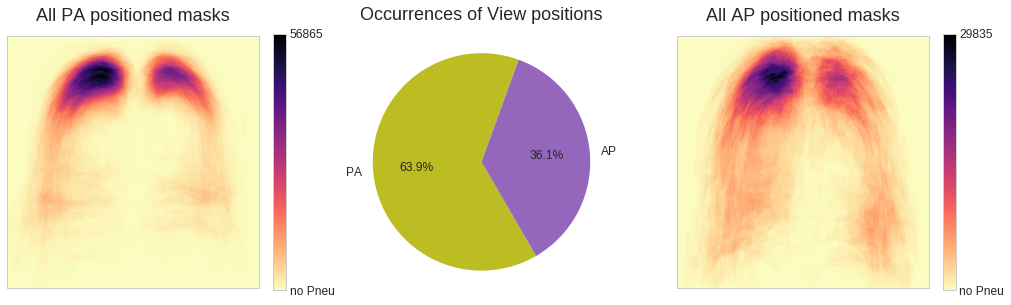

In [16]:
fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax1.imshow(pa_sum, cmap='magma_r')
ax1.set_title("All PA positioned masks", fontsize=18, pad=15)

#colorbar
maxval = np.max(pa_sum)
cmap = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ticks=[1/(maxval+1)/2, 0.5, 1-1/(maxval+1)/2]

cb_1 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax1)#ticks and boundaries
cb_1.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_1.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

ax2 = plt.subplot2grid((1, 3), (0, 1))
ax2.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
ax2.set_title("Occurrences of View positions", fontsize=18)

ax3 = plt.subplot2grid((1, 3), (0, 2))
ax3.imshow(ap_sum, cmap='magma_r')
ax3.set_title("All AP positioned masks", fontsize=18, pad=15)

maxval = np.max(ap_sum)
cmap2 = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_2 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax3)#ticks and boundaries
cb_2.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_2.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

It seems that in both cases the top left corner of the lung is the most common location. In the PA cases, the x-ray images create a cleaner view, the lungs are outlined, while the general lungs of AP cases are noisier and have orange tone. From the colorbar can be read the maximum number of overlapped pixels.

<a class="anchor" id="section7"></a>
## 7. Conclusion

So these were some brief explorations to get a bit more insight into the dataset and its metadata. We have seen the gender and age distributions of healthy and ill people, we discovered more about the x-ray image view positions and about the affected areas. Hopefully, it was useful to understand a bit the nature of the disease and of the affected people.

## Benchmark \ Baseline U-net

In [ ]:
# from: https://github.com/qubvel/segmentation_models.pytorch


model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)
